# Deep Q Learning

### Playing CartPole game using Deep Q Learning
Consider the game of CartPole-v0. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. So, there are 2 actions [Push cart to the left, Push cart to the right] that we can perform on the system. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole doesn't fall off. The episode ends when the pole falls, or the cart moves more than 2.4 units from the center.

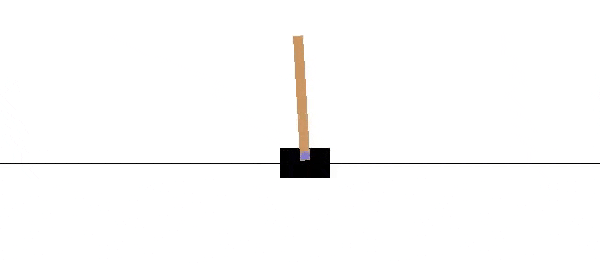

### Define the environment
For the environment, we will be using the open source gym library. Given an action, the environment will give the next state, reward, and will also tell if the game has ended or not. 

Source: https://gym.openai.com/docs/

Reference: https://github.com/rlcode/reinforcement-learning

### Notation:
1. '<b>Observation</b>' is used instead of '<b>State</b>'. Both are same.
2. <b>Episode</b>: Episode is a sequence of states, actions and rewards, until the terminal state is reached. 
3. <b>reward</b>: Immmediate reward after taking an action
4. <b>done</b>: Check if the episode has reached the terminal state

### Sample code for using the gym library
```python
import gym
env = gym.make('CartPole-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        # Take action in the current state, the environment will next state (observation), get reward and check if has reached the end state
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
```



### Model
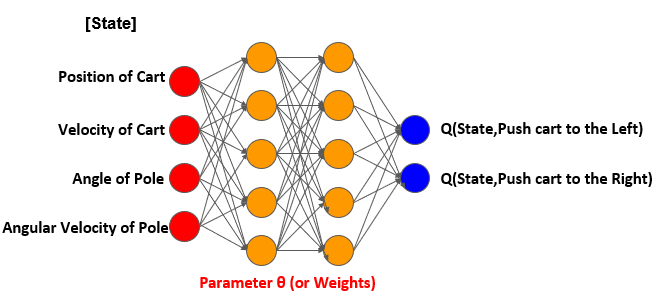

### Training

1. Initilise 2 multilayer perceptron, one for the current Q-value and another for the target Q-value
2. Generate multiple episodes. 
3. At each timestep in a episode, take action according to the ε-greedy policy and use current Q-value network for generating actions. Go to the next state. 
4. Store the sample <s, a, r, s',done> and save it in memory.
5. Take a random batch of batch size from the memory and train the network.
6. Set the target as $R_t + γ∗max Q_t(S_{t+1},a)−Q_t(S_t,a)$
7. Update the current Q-value network after every timestep in a episode.  
8. Update the target Q-value network to current Q-value network after training for a episode. This means that weights a biases of target Q-value network will become same as current Q-value network.


Import libraries

In [1]:
#Update pyglet library
!pip install pyglet==1.2.4

In [2]:
import sys
import gym
import pylab
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import model_from_json


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Display the environment

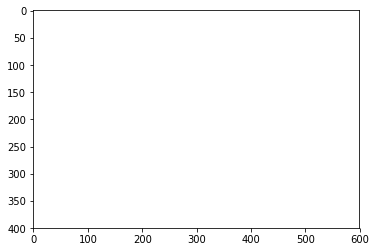

In [3]:
env = gym.make('CartPole-v0')
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) 
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
env.close()    
    

In [4]:
import os
directory_model = 'save_model'
directory_graph = 'save_graph'

#directory = 'save_graph'
if not os.path.exists(directory_model):
    os.makedirs(directory_model)

if not os.path.exists(directory_graph):
    os.makedirs(directory_graph)    

Defining the maximum number of episodes

In [5]:
EPISODES = 1000

## Steps to follow to train the model

Set the values of the hyperparameter and initialize the neural network model through the command
```python
agent = DQNAgent(state_size, action_size)
```

### Hyperparameters

- discount_factor: discount factor gamma
- learning_rate: learning rate of the model
- epsilon: Initial value of ε for ε-greedy policy
- epsilon_decay: Decay rate of ε
- epsilon_min: Minimum value of ε. Cannot decay beyound this value
- batch_size: Batch size to train the network
- train_start: Minimum samples required in memory to start training the network
- memory : deque(maxlen=1000) : Size of the memory to store samples 

 

### Training the model

We know the update policy for Q-learning as:
$Q_{t} (S_{t}, a) = Q_{t}  (S_{t}, a) + \alpha (R_{t+1} + \gamma *  \max\limits_a  Q_{t}(S_{t+1}, a) - Q_{t} (S_{t}, a)]$


$Target : reward + (discount  \: Factor) * (max(next \: Q \: value))$
 

Finally, we will train the model 


In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        
        # If you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        
        
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        
        self.batch_size = 32
        self.train_start = 500
        
        # create replay memory using deque
        self.memory = deque(maxlen=1000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.update_target_model()
        
        #self.save_model_graph()

        #if self.load_model:
        self.model.load_weights("./save_model/cartpole_dqn.h5")
        self.epsilon = 0.0

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        '''
        TODO:
        Build multilayer perceptron to train the Q(s,a) function. In this neural network, the input will be states and the output 
        will be Q(s,a) for each (state,action). 
        Note: Since the ouput Q(s,a) is not restricted from 0 to 1, we use 'linear activation' as output layer.

        Loss Function:
        Loss=1/2 * (R_t + γ∗max Q_t (S_{t+1},a)−Q_t(S_t,a)^2
               which is 'mean squared error'

        '''
        
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def save_model_graph(self):
        # serialize model to JSON
        model_json = self.model.to_json()
        with open("./save_model/cartpole_dqn_model.json", "w") as json_file:
            json_file.write(model_json)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        '''
        TODO:
        Update the target Q-value network to current Q-value network after training for a episode. This means that weights an
        biases of target Q-value network will become same as current Q-value network.
        '''
        self.target_model.set_weights(self.model.get_weights())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        '''
        Select action
        Args:
            state: At any given state, choose action
        
        TODO:
        Choose action according to ε-greedy policy. We generate a random number over [0, 1) from uniform distribution.
        If the generated number is less than ε, we will explore, otherwise we will exploit the policy by choosing the
        action which has maximum Q-value.
        
        More the ε value, more will be exploration and less exploitation.
        
        '''
        # choose random action if generated random number is less than ε.
        # Action is represented by index, 0-Number of actions, like (0,1,2,3) for 4 actions
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        '''
        Save sample in memory and decay ε after we generate each sample from environment. 
        
        Args:
            (state, action, reward, next_state, done)- <s,a,r,s',done> 
        
        TODO:
            We are saving each sample  (state, action, reward, next_state, done) of the episode, in a memory. Memory can be 
            defined by queue. We will dequeue sample of batch size from the memory and use it to train the neural network.
            
            ε-decay:
            With ε, we explore and with 1-ε, we exploit. Initially we want to explore more, but at later point, after training 
            the model, we have good policy to choose better action. So, at that point, we want to expoit more and explore less.
            So, we want to decrease the value of ε, by which we explore. 
            
            self.epsilon_min:
            Minimum value of ε, by which we want to explore. If the current value of ε is greater then 
            minimum value to ε, we will decay ε gradually, when generating samples. 
            
            Note: The rate by which we will decrease ε should be slow, otherwise we will not explore much and instead settle
            for suboptimal policy instead of optiomal policy. 
    
        '''
        # Adding sample to the memory. 
        self.memory.append((state, action, reward, next_state, done))
        
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        '''
        Train the neural network to find the best policy
        
        TODO:
        1. Sample <s,a,r,s',done> of batch size from the memory
        2. Set the target as R_t + γ∗max Q_t(S_{t+1},a)−Q_t(S_t,a)
        3. Set the target only for the action we took in the environment. For the other actions, we don't wan't to 
        update the network. 
        4. Remember that we already the actions that we took when generating sample from environment
        4. To find the Q_t(S_{t+1},a), we input the next state s' to the model, and we get Q-value for all the actions
        5. To find the Q_t(S_t,a), we input the current state s to the model, and we get Q-value for all the actions
        6. Train the model
        
        Note:
        We use 2 different neural network for Q_t(S_t,a) and target Q_t(S_{t+1},a). This is so because we are 
        constantly updating the current Q-value network at each and every timestep in a episode. Therefore, the target 
        Q-value will change subsequently. The network can become destabilized by falling into feedback loops between the
        target and current Q-values.
        We update the target Q-value network only after completion of a batch. We update the target Q-value with the 
        current Q-value network. 
        
        '''
        # We start the training only when we have sufficient sample in the memory. We set the number of samples required
        # start training in variable train_start
        if len(self.memory) < self.train_start:
            return
        
        # Sample batch from the memory
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)
     
        # Initialise the variables update_input and update_target for a batch for storing the s and s'.
        # Later, we will use it to store Q_t(S_t,a_t) and Q_t(S_{t+1},a)
        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        # Set the values of input, action, reward, target and done using memory
        # Note the order of <s,a,r,s',done> 
        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        # Set the target as Q values predicted from the current state and next state 
        # store Q_t(S_t,a_t) and Q_t(S_{t+1},a) in target and target_val
        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)
        
        
        # Update the target value according to the update policy of Q-learning
        # R_t + γ ∗ max Q_t(S_{t+1},a)−Q_t(S_t,a_t)
        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        # and do the model fit!
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)


### Main function
Here, we will generate samples <s, a, r, s'> in episodes using the environment. Save these samples in memory and train the model.
If the mean of scores of last 30 episode is bigger than 490 stop training.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_11 (Dense)             (None, 32)  

episode: 86   score: 152.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 87   score: 179.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 88   score: 140.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 89   score: 172.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 90   score: 147.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 91   score: 167.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 92   score: 145.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 93   score: 217.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 94   score: 165.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 95   score: 138.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 96   score: 157.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 97   score: 177.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 98   score: 197.0  

episode: 187   score: 136.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 188   score: 271.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 189   score: 192.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 190   score: 185.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 191   score: 232.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 192   score: 165.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 193   score: 143.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 194   score: 189.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 195   score: 96.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 196   score: 205.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 197   score: 186.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 198   score: 96.0   memory length: 1000   epsilon: 0.009998671593271896
episode: 199   sco

SystemExit: 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


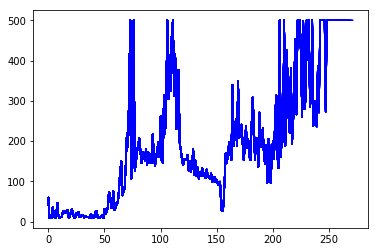

In [9]:
'''
TODO:
    1. Generate multiple epoisdes 
    2. At each timestep in a episode, store the sample <s, a, r, s',done> and save it in memory. Then, take a random batch
    of batch size from the memory and train the network.
    3. Take action according to the ε-greedy policy and go the next state. 
    4. Update the current Q-value network after every timestep in a episode.  
    5. Update the target Q-value network to current Q-value network after training for a episode. This means that weights an
    biases of target Q-value network will become same as current Q-value network.
    
Note: Penalty of -100 is added if an action make the episode end.
    
'''

if __name__ == "__main__":
      
    
    env = gym.make('CartPole-v1')
    
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100

            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            
            # every time step do the training
            agent.train_model()
            
            score += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # adding +100 to score because initially we subtracted 100 for not completing the episode
                score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./save_graph/cartpole_dqn.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)

                # if the mean of scores of last 30 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(30, len(scores)):]) > 490:
                    agent.model.save_weights("./save_model/cartpole_dqn.h5")
                    sys.exit()

        #save the model 
        if e % 50 == 0:
            agent.model.save_weights("./save_model/cartpole_dqn.h5")
            
       

In [13]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
score = 0
state = env.reset()
state = np.reshape(state, [1, state_size])
done = False

# Run the model for single episode
while not done:
    # env.render()
    action = agent.get_action(state)
    next_state, reward, done, info = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    score += reward
    
print('Score is ', score)
env.close()   
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_29 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_30